### Objective: isolate plants that fall on the "planting line" to remove noise and improve plant count accuracy.

In [1]:
import re
import statistics as st
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
df_contour = pd.read_csv('/home/will/plant_count_data_countour.csv', header=[0])
df_green_pix = pd.read_csv('/home/will/plant_count_data_green_pix.csv', header=[0])

In [3]:
df_contour = df_contour.apply(pd.to_numeric, errors='ignore')
df_green_pix = df_green_pix.apply(pd.to_numeric, errors='ignore')

In [4]:
un_id_cont = list(set(df_contour['id_and_rt'].values))
un_id_gp = list(set(df_green_pix['id_and_rt'].values))

### Results from the contouring method:

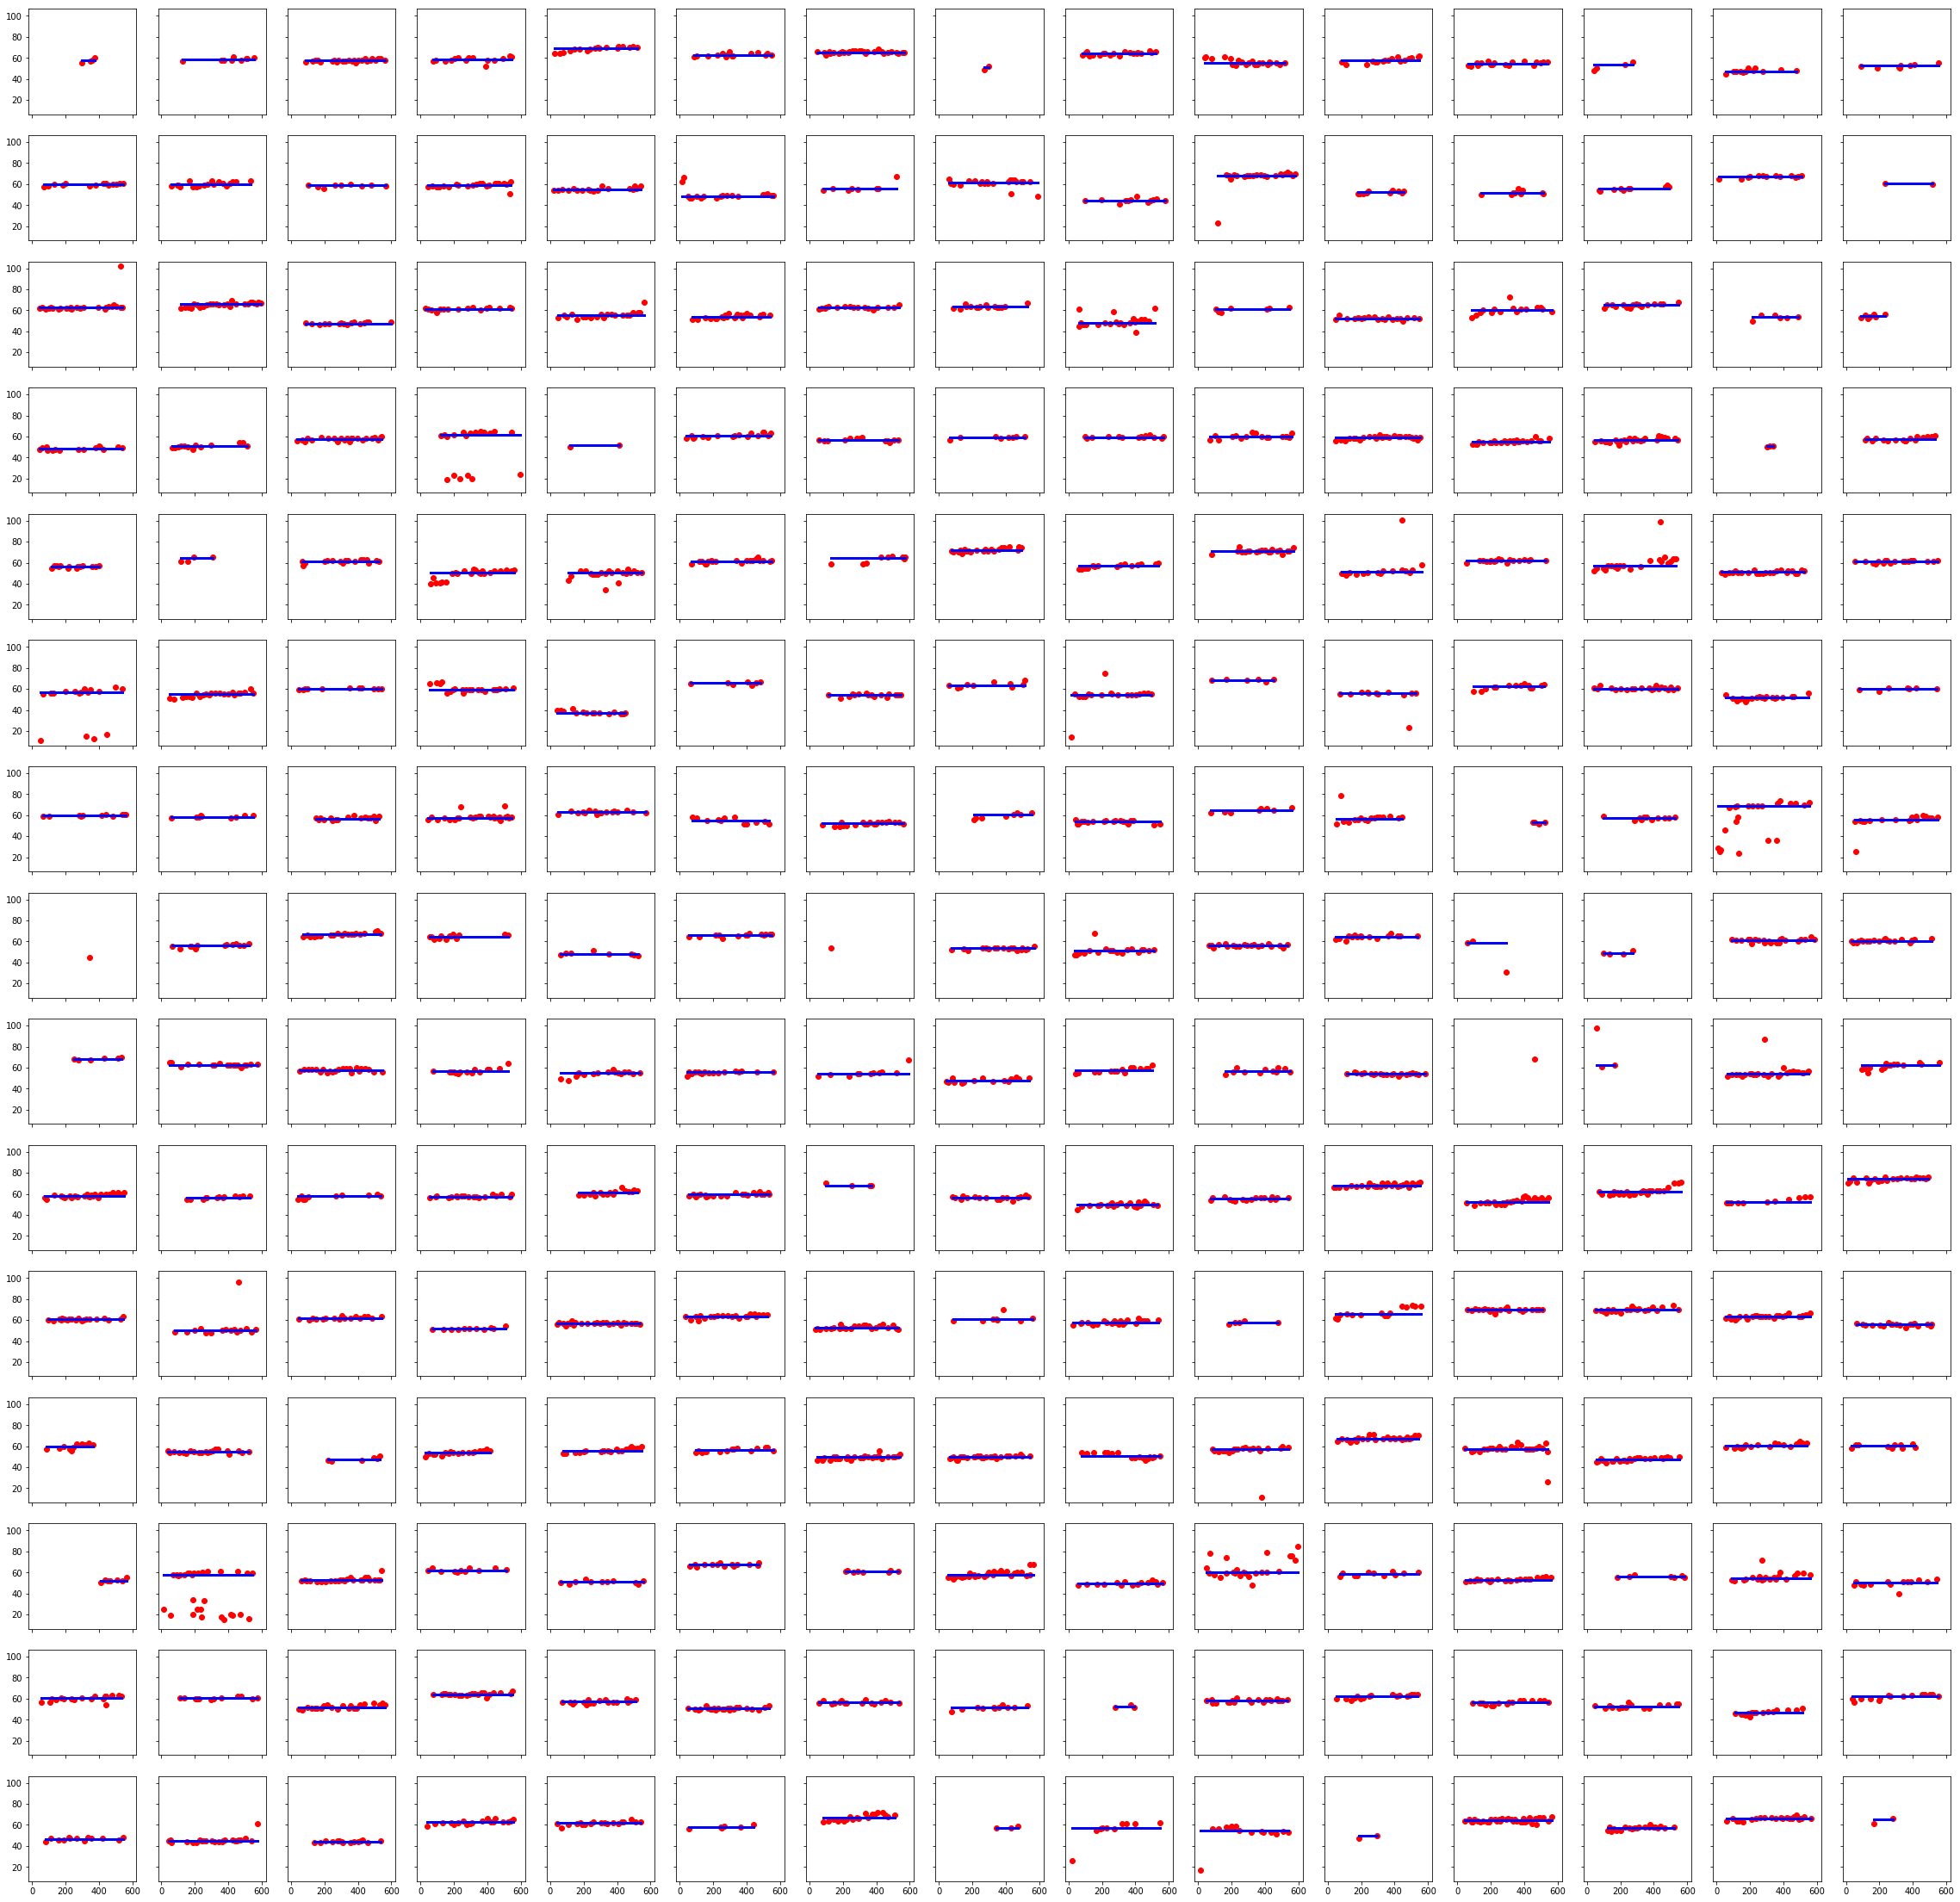

In [5]:
fig, axs = plt.subplots(15,15, figsize=(40,40), sharex=True, sharey=True)
for i, ax in zip(un_id_cont[:225], axs.ravel()):
    x = df_contour.loc[(df_contour['id_and_rt']==i), 'x'].values
    y = df_contour.loc[(df_contour['id_and_rt']==i), 'y'].values
    
    y_mode = [st.median_grouped(y)] * len(y)
    
    ax.plot(x,y, 'ro')
    ax.plot(x,y_mode, 'b-', linewidth=3)

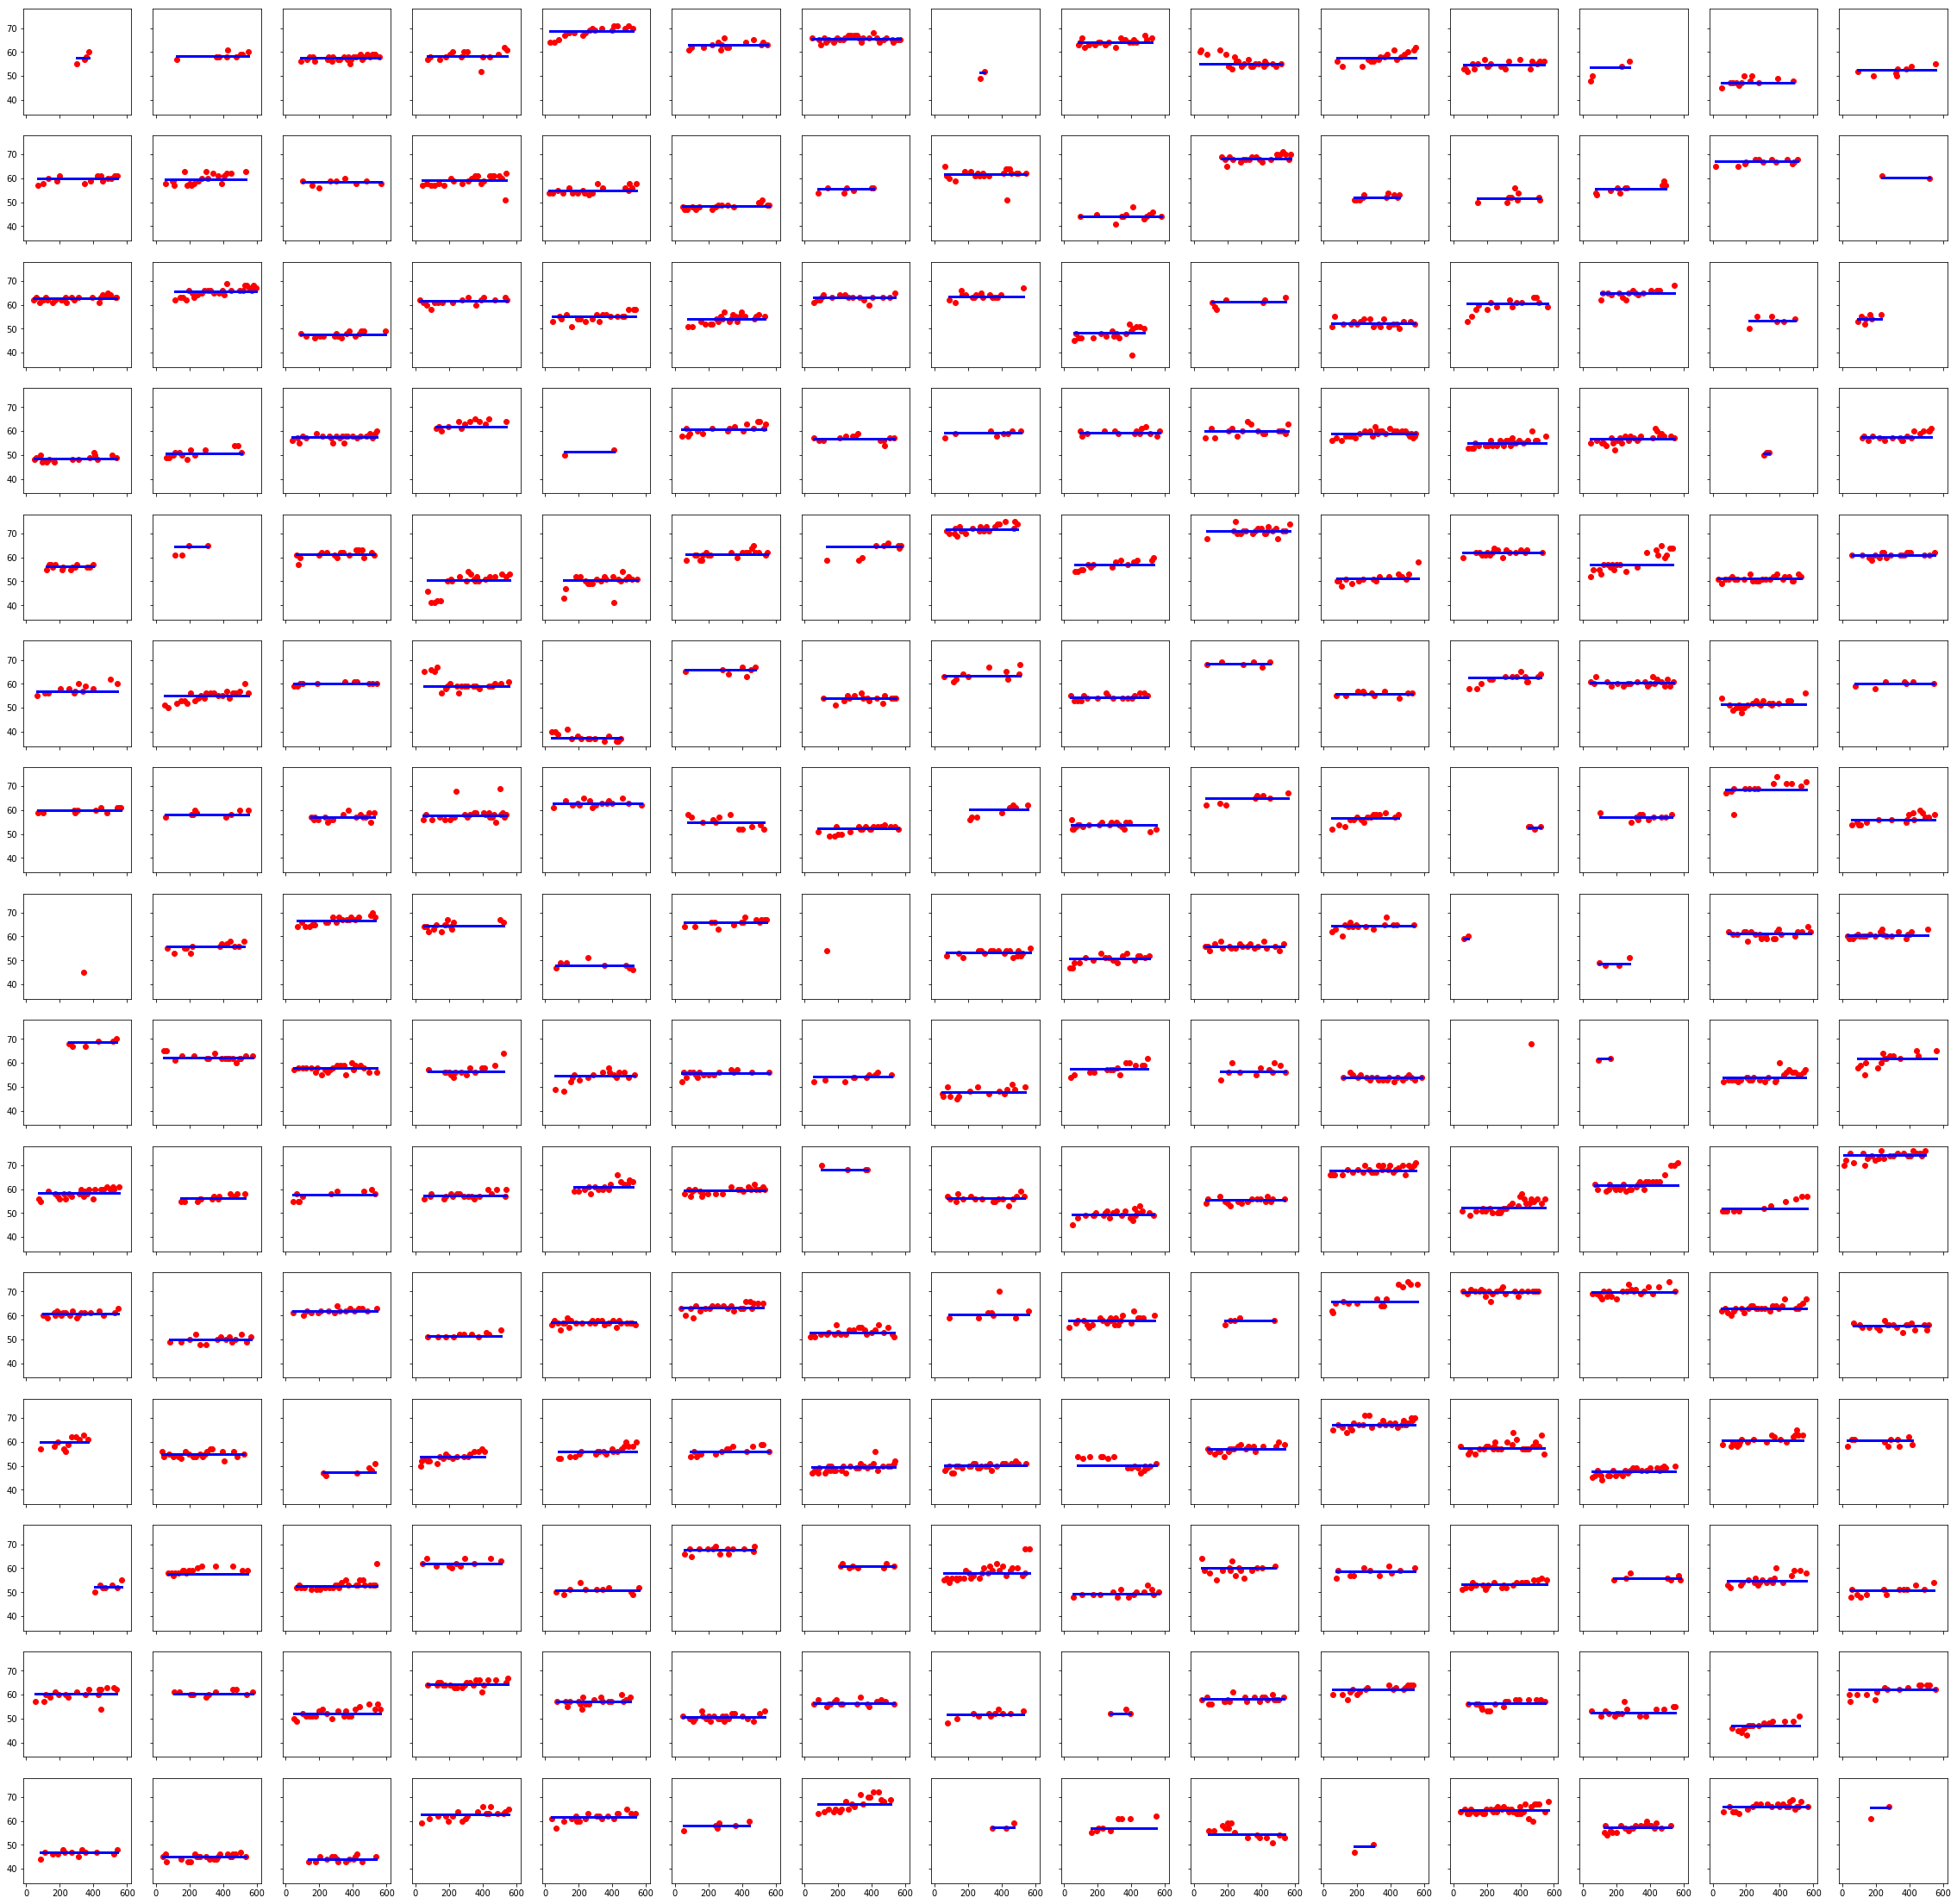

In [6]:
fig, axs = plt.subplots(15,15, figsize=(40,40), sharex=True, sharey=True)
for i, ax in zip(un_id_cont[:225], axs.ravel()):
    x = df_contour.loc[(df_contour['id_and_rt']==i), 'x'].values
    y = df_contour.loc[(df_contour['id_and_rt']==i), 'y'].values
    
    y_mode = [st.median_grouped(y)]
    
    cutoff = 20
    
    x_y = [i for i in zip(x,y) if (np.abs(i[1]-y_mode)/y_mode)*100 < cutoff]
    
    x = [i[0] for i in x_y]
    y = [i[1] for i in x_y]
    
    ax.plot(x,y, 'ro')
    ax.plot(x,y_mode * len(y), 'b-', linewidth=3)

In [7]:
plant_counts = []

for i in un_id_cont:
    
    id_parts = re.split('__', i)
    
    x = df_contour.loc[(df_contour['id_and_rt']==i), 'x'].values
    y = df_contour.loc[(df_contour['id_and_rt']==i), 'y'].values
    area = df_contour.loc[(df_contour['id_and_rt']==i), 'area'].values
    
    n = len(y)
    
    y_mode = [st.median_grouped(y)]
    
    percent_off = 10
    
    count = len([y for x,y in zip(x,y) if (np.abs(y-y_mode)/y_mode)*100 < percent_off])
    
    area_sum = sum([area for area,y in zip(area,y) if (np.abs(y-y_mode)/y_mode)*100 < percent_off])
    
    id_only = id_parts[0]
    row = id_parts[1]
    tier = id_parts[2]
    
    plant_counts.append((id_only,row,tier,count, area_sum))

In [8]:
df_counts = pd.DataFrame(plant_counts, columns=['id','row','tier','drone_count', 'area_sums'])

In [9]:
df_counts[:10]

,id,row,tier,drone_count,area_sums
0,17TXRW7018-20,row-1,tier-2,4,78.5
1,18PS7027,row-44,tier-11,9,259.5
2,18PS7047,row-42,tier-13,26,809.0
3,18PS5167,row-33,tier-18,14,524.0
4,18PS5042,row-28,tier-6,18,742.5
5,17TXSU_9054,row-48,tier-15,15,387.0
6,18PS8042,row-43,tier-19,29,1671.0
7,PHY375,row-56,tier-8,2,46.0
8,18PS3037,row-19,tier-12,20,547.5
9,18PS5068,row-34,tier-8,21,960.0


In [10]:
df_ground_truth = pd.read_excel('/home/will/mauricio_plant_count_data_2018.xlsx', sheet_name=[0,1,2,3,4,5,6,7,8,9])

In [11]:
df_ground_truth_long = pd.concat(df_ground_truth, axis=0)

In [12]:
df_ground_truth_long['06/26-27/18 \nStand Counts'] = pd.to_numeric(df_ground_truth_long['06/26-27/18 \nStand Counts'], errors='coerce')

In [13]:
dict = {
    'id':df_ground_truth_long.loc[:,'Plot_No.'].values,
    'hand_count':df_ground_truth_long.loc[:,'06/26-27/18 \nStand Counts'].values,
}

In [14]:
df_ground = pd.DataFrame(dict)

In [15]:
df_ground[:10]

,hand_count,id
0,32.0,18PS0001
1,47.0,18PS0002
2,35.0,18PS0003
3,15.0,18PS0004
4,28.0,18PS0005
5,25.0,18PS0006
6,15.0,18PS0007
7,38.0,18PS0008
8,21.0,18PS0009
9,42.0,18PS0010


In [16]:
df1 = pd.merge(df_counts, df_ground, on='id')

Text(0,0.5,'drone count')

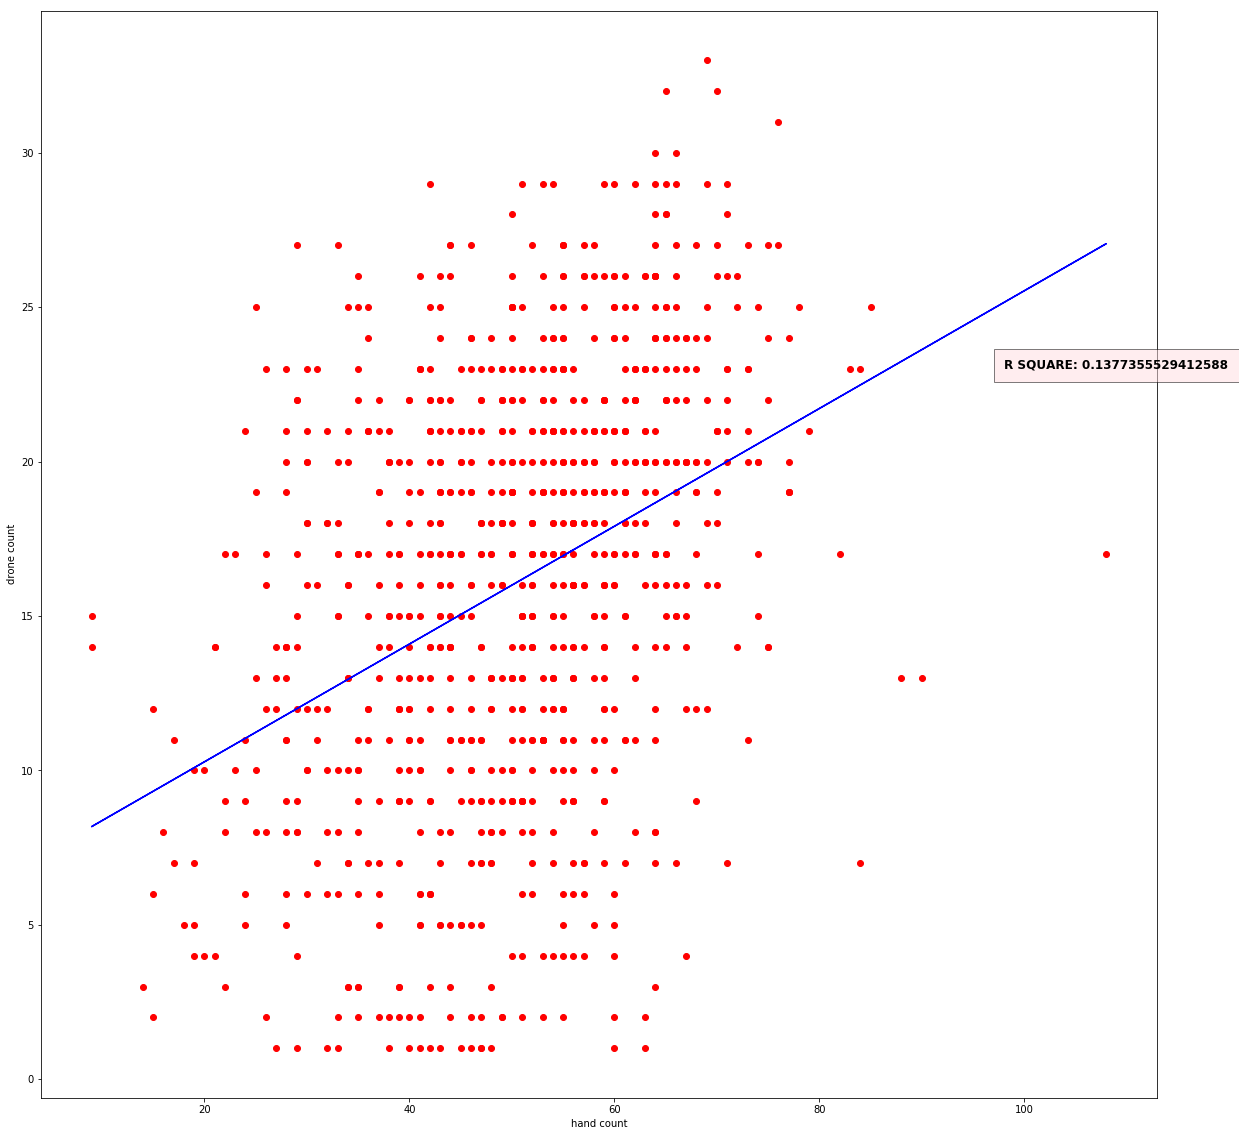

In [17]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
x = df1.loc[:, 'hand_count']
y = df1.loc[:, 'drone_count']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

y_hat = [slope*i + intercept for i in x]

ax.plot(x,y, 'ro')
ax.plot(x,y_hat, 'b-')
ax.text(max(x) - 10, max(y) - 10, 'R SQUARE: {0} '.format(r_value**2), weight='bold',fontdict={'fontsize':12}, bbox={'facecolor':'#FFDDE1', 'alpha': 0.5, 'pad': 10})
ax.set_xlabel('hand count')
ax.set_ylabel('drone count')

Text(0,0.5,'area sums')

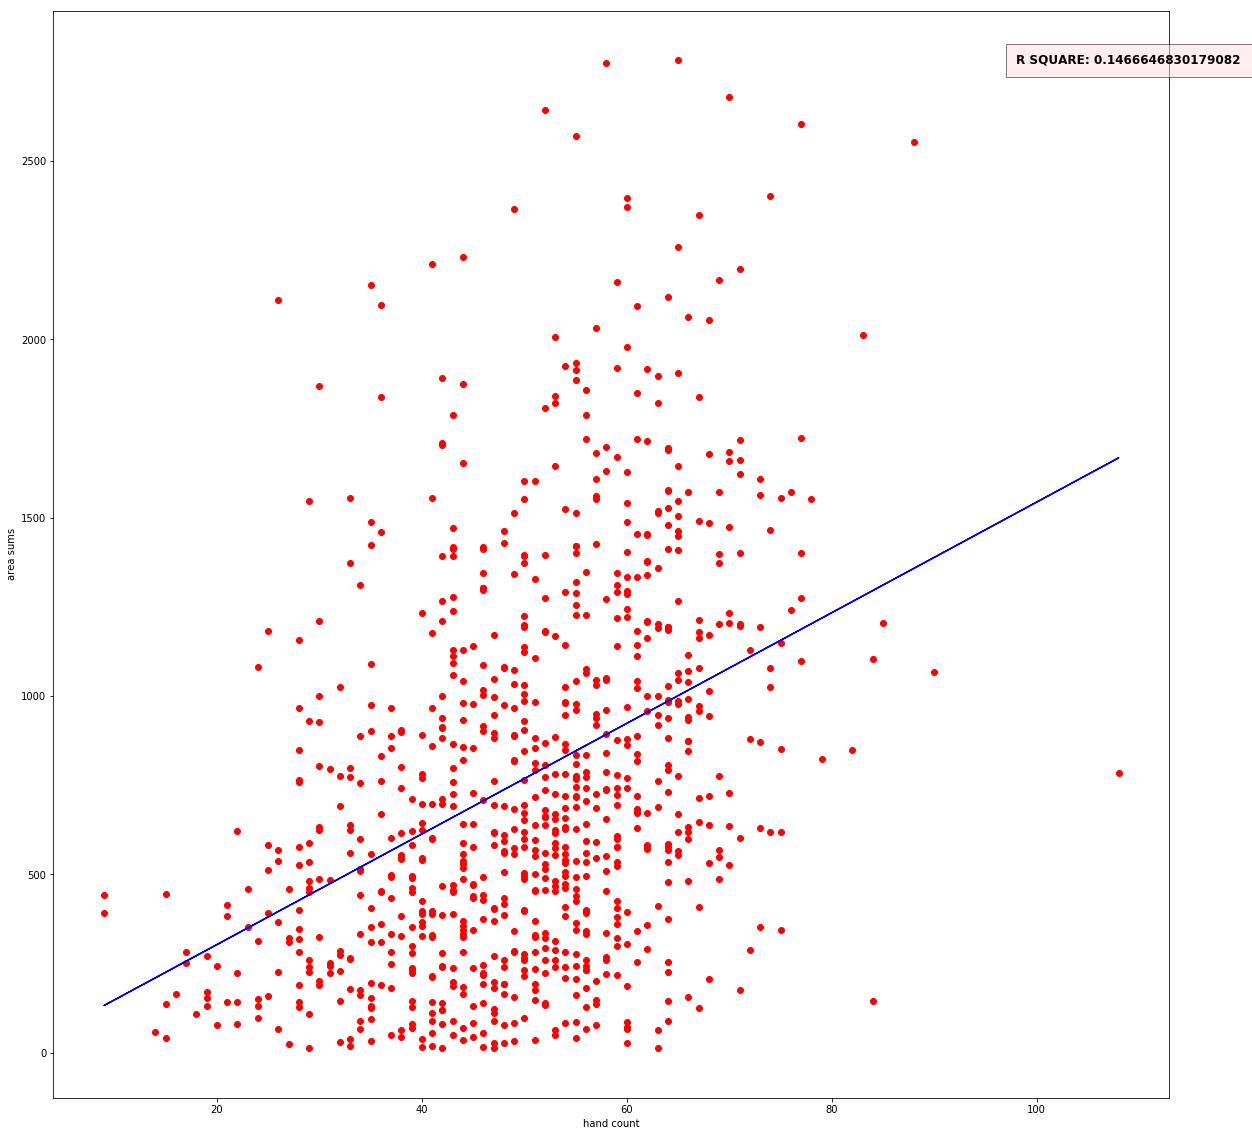

In [18]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
x = df1.loc[:, 'hand_count']
y = df1.loc[:, 'area_sums']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

y_hat = [slope*i + intercept for i in x]

ax.plot(x,y, 'ro')
ax.plot(x,y_hat, 'b-')
ax.text(max(x) - 10, max(y) - 10, 'R SQUARE: {0} '.format(r_value**2), weight='bold',fontdict={'fontsize':12}, bbox={'facecolor':'#FFDDE1', 'alpha': 0.5, 'pad': 10})
ax.set_xlabel('hand count')
ax.set_ylabel('area sums')

### Results for green pixel count method:

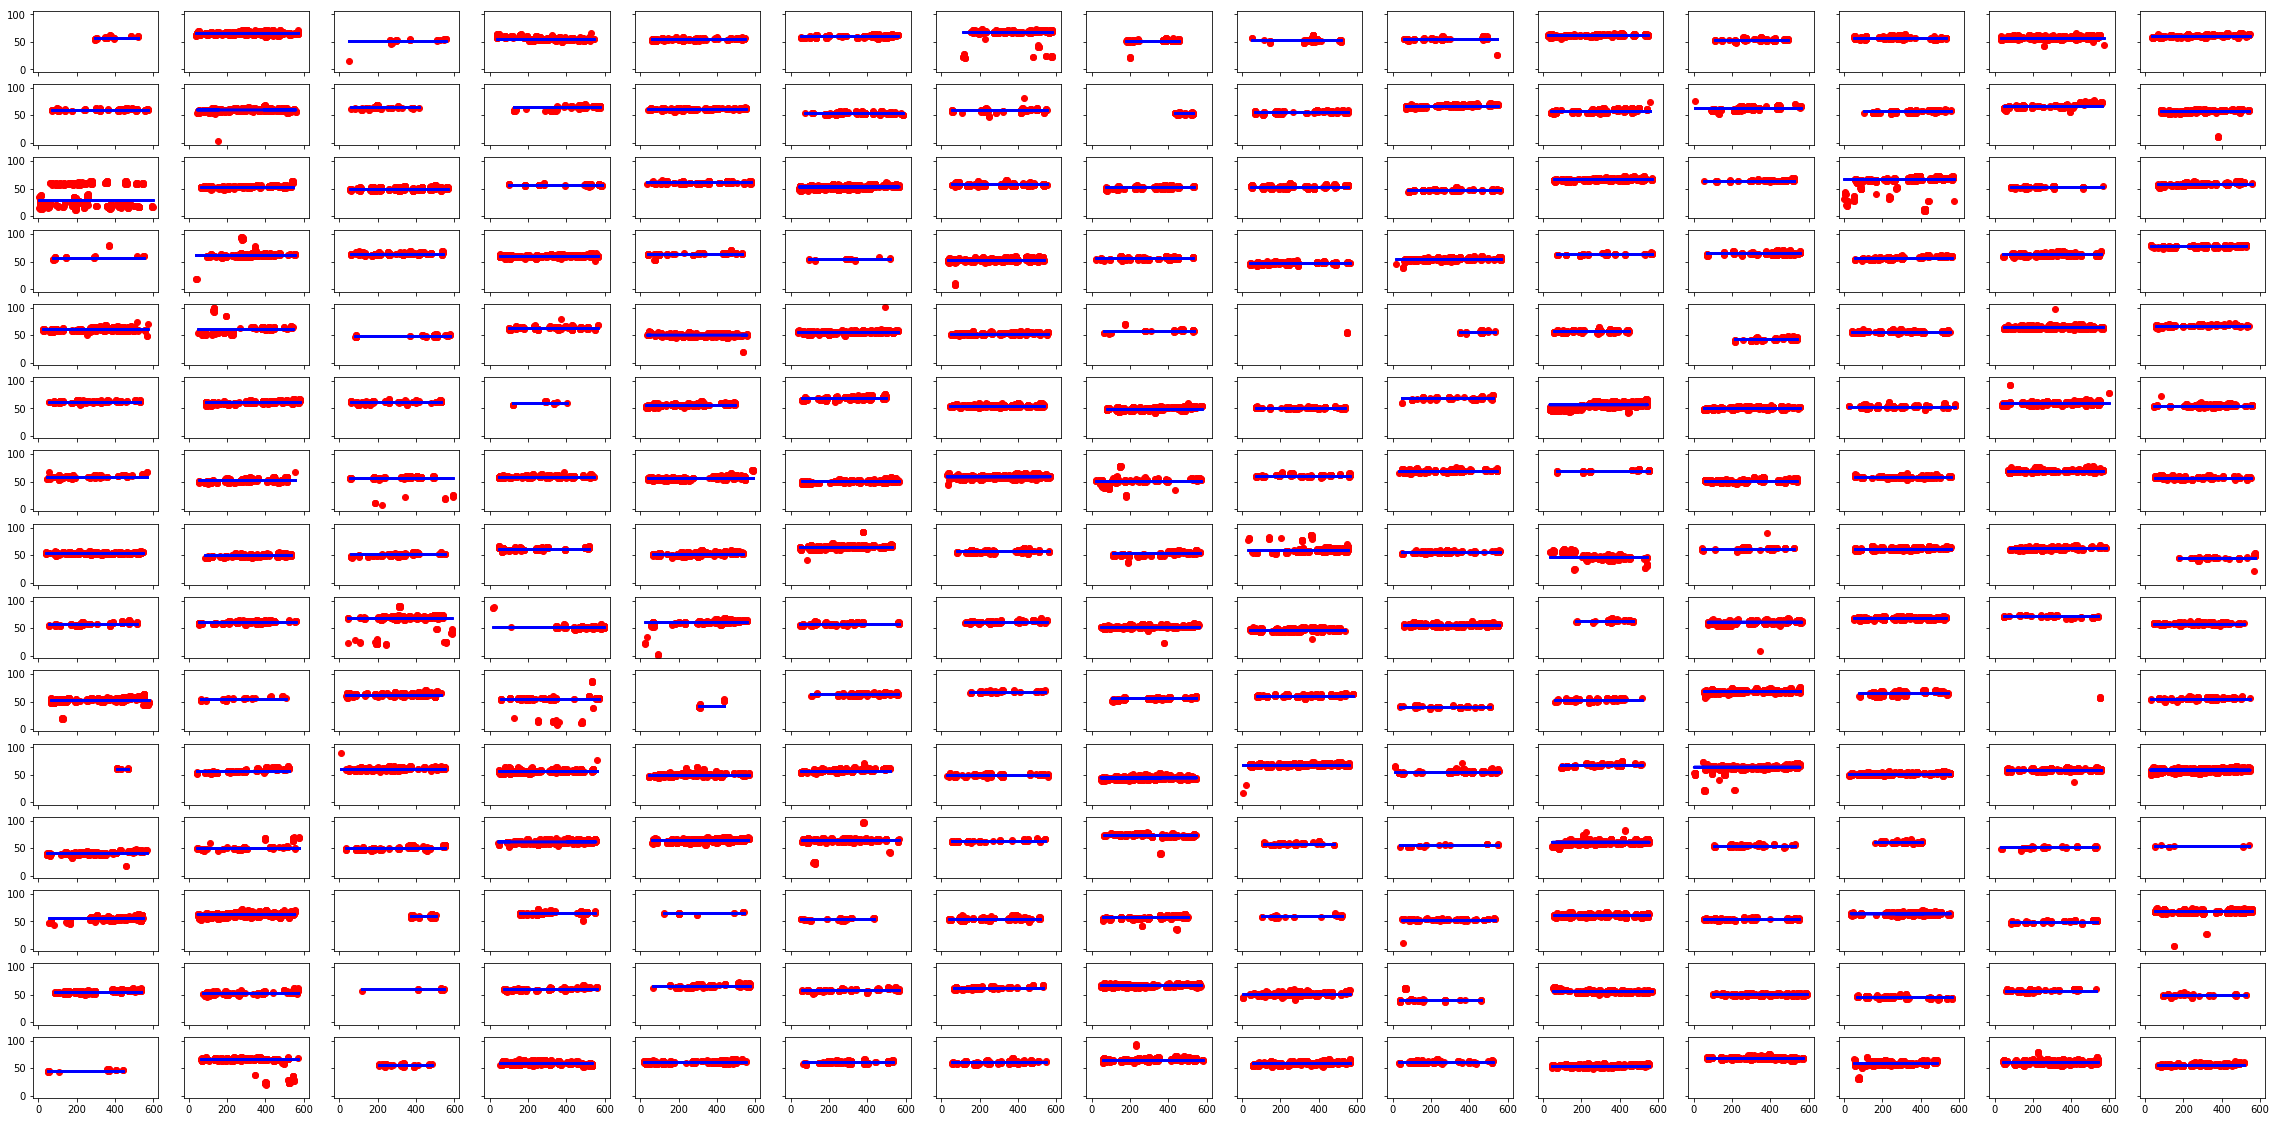

In [19]:
fig, axs = plt.subplots(15,15, figsize=(40,20), sharex=True, sharey=True)
for i, ax in zip(un_id_gp[:225], axs.ravel()):
    x = df_green_pix.loc[(df_green_pix['id_and_rt']==i), 'x_green'].values
    y = df_green_pix.loc[(df_green_pix['id_and_rt']==i), 'y_green'].values
    
    y_mode = [st.median_grouped(y)] * len(y)
    
    ax.plot(x,y, 'ro')
    ax.plot(x,y_mode, 'b-', linewidth=3)

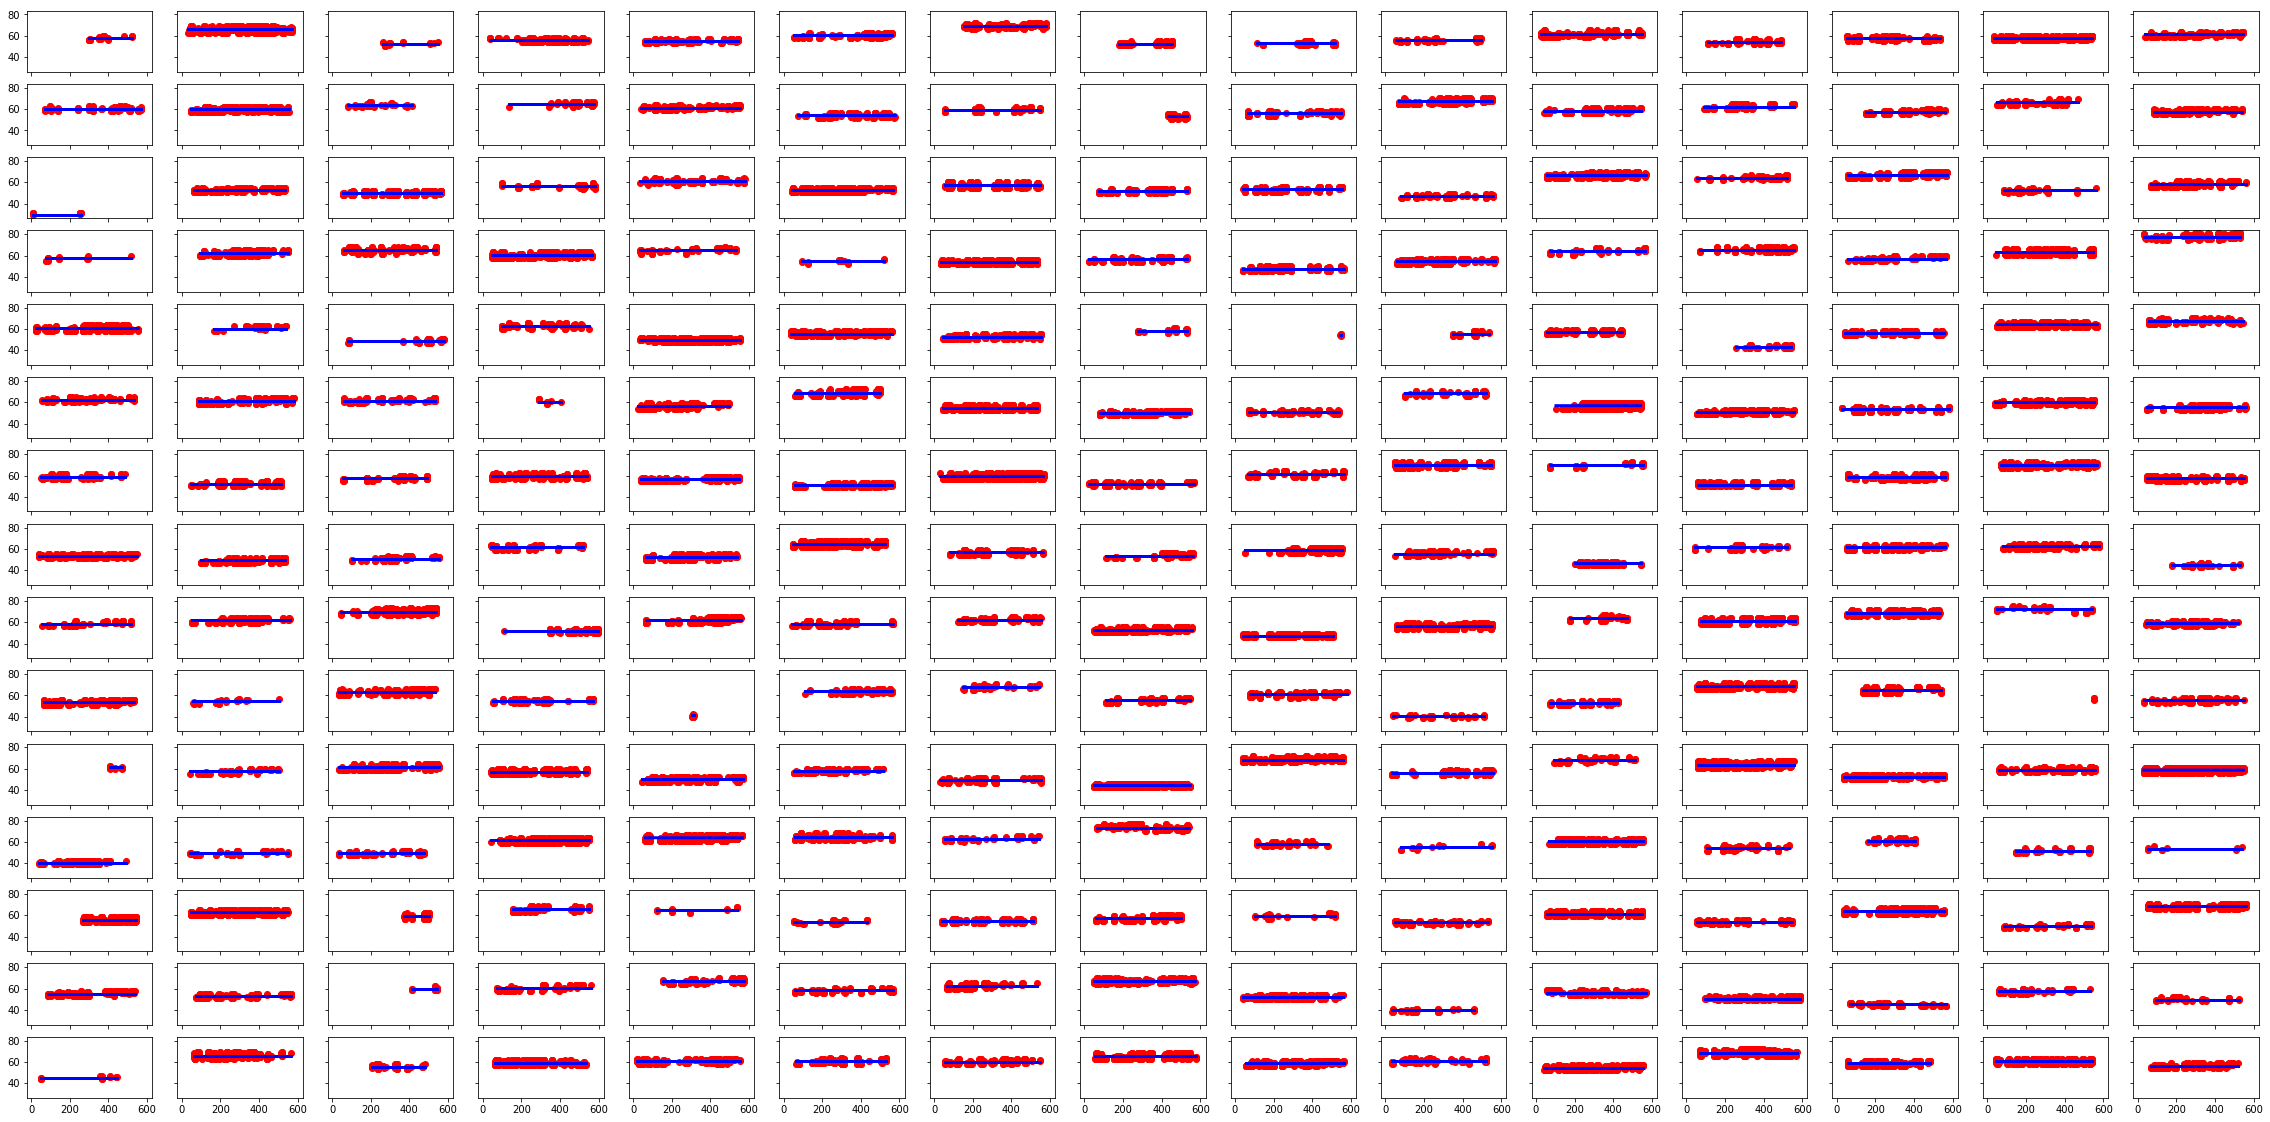

In [20]:
fig, axs = plt.subplots(15,15, figsize=(40,20), sharex=True, sharey=True)
for i, ax in zip(un_id_gp[:225], axs.ravel()):
    x = df_green_pix.loc[(df_green_pix['id_and_rt']==i), 'x_green'].values
    y = df_green_pix.loc[(df_green_pix['id_and_rt']==i), 'y_green'].values
    
    y_mode = [st.median_grouped(y)]
    
    cutoff = 5
    
    x_y = [i for i in zip(x,y) if (np.abs(i[1]-y_mode)/y_mode)*100 < cutoff]
    
    x = [i[0] for i in x_y]
    y = [i[1] for i in x_y]
    
    ax.plot(x,y, 'ro')
    ax.plot(x,y_mode * len(y), 'b-', linewidth=3)

In [21]:
pix_counts = []

for i in un_id_gp:
    
    id_parts = re.split('__', i)
    
    x = df_green_pix.loc[(df_green_pix['id_and_rt']==i), 'x_green'].values
    y = df_green_pix.loc[(df_green_pix['id_and_rt']==i), 'y_green'].values
    
    n = len(y)
    
    y_mode = [st.median_grouped(y)]
    
    percent_off = 5
    
    count = len([y for x,y in zip(x,y) if (np.abs(y-y_mode)/y_mode)*100 < percent_off])
    
    id_only = id_parts[0]
    row = id_parts[1]
    tier = id_parts[2]
    
    pix_counts.append((id_only,row,tier,count))

In [22]:
df_counts_gp = pd.DataFrame(pix_counts, columns=['id','row','tier','pix_count'])

In [23]:
df1 = pd.merge(df_counts_gp, df_ground, on='id')

In [24]:
df1.to_csv('/home/will/pix_count_vs_hand_2018-09-06.csv')

In [25]:
df1.loc[(df1['id']=='18PS0003')]

,id,row,tier,pix_count,hand_count
23,18PS0003,row-17,tier-20,529,35.0


ValueError: x and y must have same first dimension, but have shapes (909,) and (3,)

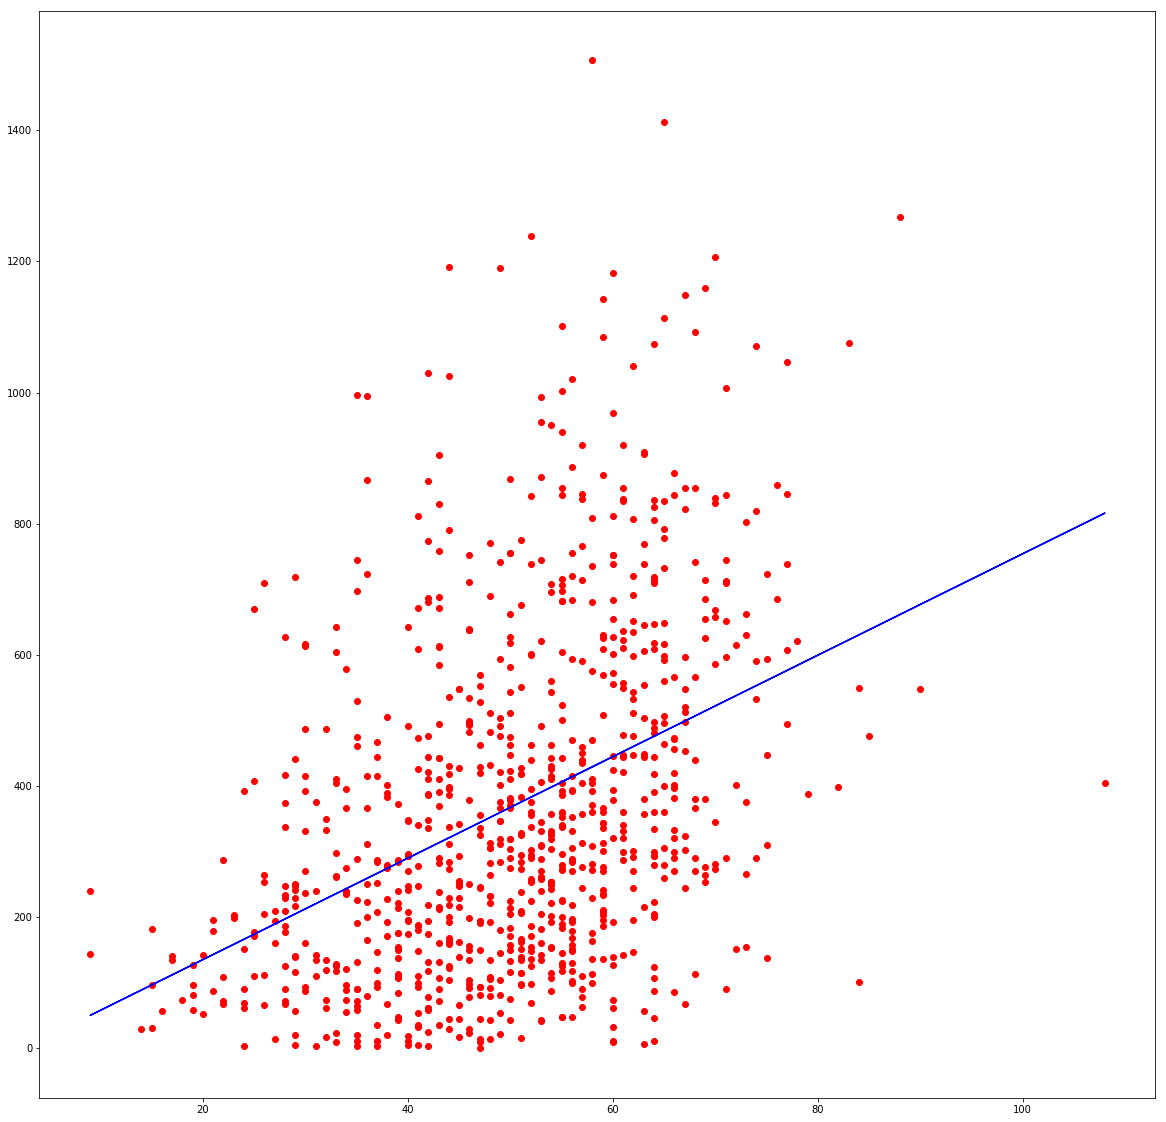

In [29]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
x = df1.loc[:, 'hand_count']
y = df1.loc[:, 'pix_count']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

coeffs = np.polyfit(x,y,2)
p = np.poly1d(coeffs)

y_hat = [slope*i + intercept for i in x]

ax.plot(x,y, 'ro')
ax.plot(x,y_hat, 'b-')
ax.plot(x,p, 'g-')
ax.text(max(x) - 10, max(y) - 10, 'R SQUARE: {0} '.format(r_value**2), weight='bold',fontdict={'fontsize':12}, bbox={'facecolor':'#FFDDE1', 'alpha': 0.5, 'pad': 10})
ax.set_xlabel('hand_count')
ax.set_ylabel('pix_count')

fig, ax = plt.subplots(1,1, figsize=(20,20))
x = df1.loc[:, 'hand_count']
y = df1.loc[:, 'pix_sums']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

y_hat = [slope*i + intercept for i in x]

ax.plot(x,y, 'ro')
ax.plot(x,y_hat, 'b-')
ax.text(max(x) - 10, max(y) - 10, 'R SQUARE: {0} '.format(r_value**2), weight='bold',fontdict={'fontsize':12}, bbox={'facecolor':'#FFDDE1', 'alpha': 0.5, 'pad': 10})
ax.set_xlabel('hand count')
ax.set_ylabel('area sums')

In [ ]:
r_value**2

In [ ]:
from 

In [ ]:
un_id_gp

In [ ]:
this = df_counts_gp.loc[:, ('id', 'pix_count')]

In [ ]:
this.set_index('id', inplace=True)

In [ ]:
that = df_ground

In [ ]:
that.set_index('id', inplace=True)

In [ ]:
that.sort_index

In [ ]:
this.sort_index

In [ ]:
pd.merge(that, this, sort=True, left_index=True, right_index=True)

In [ ]:
def angle_between_lines(slope_1, slope_2):
    angle_of_inclination_1 = np.arctan(slope_1) 
    angle_of_inclination_2 = np.arctan(slope_2)
    
    angle_diff = angle_of_inclination_1 - angle_of_inclination_2
    
    absolute_value_angle_diff = np.abs(angle_diff)
    
    return absolute_value_angle_diff

In [ ]:
angles = []

for itr,i in enumerate(line_equations):
    m_1 = i[0]
    m_2 = line_equations[itr-1][0]
    
    ang = angle_between_lines(m_1, m_2)

    angles.append(ang)

In [ ]:
plot